In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#Load already prepared CK+
def load_CKplus_full():
  x = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/inputs.csv",header=None)
  y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/labels.csv",header=None)
  x, y = shuffle(x, y,random_state = 2021)

  x = np.array(x)
  x = x.reshape(len(x),48,48,1)
  y = np.array(y)
  return x, y

def load_CKplus_split():
  x = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/inputs.csv",header=None)
  y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/labels.csv",header=None)
  x, y = shuffle(x, y,random_state = 2021)
  x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=147, random_state=2021)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=147, random_state=2021)

  x_train = np.array(x_train)
  x_train = x_train.reshape(len(x_train),48,48,1)
  y_train = np.array(y_train)
  x_test = np.array(x_test)
  x_test = x_test.reshape(len(x_test),48,48,1)
  y_test = np.array(y_test)
  x_val = np.array(x_val)
  x_val = x_val.reshape(len(x_val),48,48,1)
  y_val = np.array(y_val)
  return x_train, y_train, x_test, y_test, x_val, y_val

#Load already prepared FER2013
def load_FER2013():
  x_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_train.csv",header=None,)
  y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_train.csv",header=None)
  x_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_test.csv",header=None)
  y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_test.csv",header=None)
  x_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_val.csv",header=None)
  y_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_val.csv",header=None)

  x_train = np.array(x_train)
  x_train = x_train.reshape(len(x_train),48,48,1)
  y_train = np.array(y_train)
  x_test = np.array(x_test)
  x_test = x_test.reshape(len(x_test),48,48,1)
  y_test = np.array(y_test)
  x_val = np.array(x_val)
  x_val = x_val.reshape(len(x_val),48,48,1)
  y_val = np.array(y_val)
  return x_train, y_train, x_test, y_test, x_val, y_val


x_train, y_train, x_test, y_test, x_val, y_val = load_FER2013()
x_train.shape, x_test.shape, x_val.shape


def plot_model_history(history):
  # Plot training loss values
  print("Plot loss values (Train vs. Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'],label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

  print("Plot the accuracy (Train and Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['accuracy'],label='Training Accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


In [3]:
#face recognition packages
!pip install opencv-python
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 25 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=5855893f73b4831e9a7c55852b867a4611b8dae965c4eccb17e42051f1a4a7dc
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [10]:
#face detection, crop, sharpen, emboss using both face_recognition and cv2 packages
import face_recognition
from skimage.feature import local_binary_pattern
import cv2
import math
from google.colab.patches import cv2_imshow
from PIL import Image, ImageEnhance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def transform(img):
  if len(img.shape)>2:
    img = img.reshape(48,48)
  #gamma
  mid = 0.5 
  mean = np.mean(img)
  gamma = math.log(mid*255)/math.log(mean)
  img = np.power(img, gamma).clip(0,255).astype(np.uint8)

  #img = Image.fromarray(img)
  #filter = ImageEnhance.Contrast(img)# add contrast
  #img = filter.enhance(2)

  #img = img.filter(ImageEnhance.ImageFilter.SMOOTH)
  #img = img.filter(ImageEnhance.ImageFilter.EMBOSS)#emboss
  #img = img.filter(ImageEnhance.ImageFilter.EDGE_ENHANCE)
  
  #img = local_binary_pattern(img, 30, 1)
  #img = np.array(img)
  return img
def pre_process(input, target, output_height=48, output_width=48):
  face_cascade_name = cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml'
  face_cascade = cv2.CascadeClassifier()
  if not face_cascade.load(cv2.samples.findFile(face_cascade_name)):
    print("Error loading xml file")
    exit(0)

  x_temp = []
  y_temp = []
  #plt.figure(figsize=[8,8])
  for i in range(len(input)):
    img = np.array(input[i],'uint8')
    face_detect_1 = face_recognition.face_locations(img) #Using face_recoginition
    face_detect_2 = face_cascade.detectMultiScale(img,1.1, 1) #Using cv2
    if (len(face_detect_1)>0):
      (y, w, h, x) = face_detect_1[0]
      #img = img[y:y + h, x:x + w]
      #img = cv2.resize(img,(output_height, output_width))
      
      img = transform(img)
      img = img.reshape(output_height,output_width,1)
      x_temp.append(img)
      y_temp.append(target[i])

    elif (len(face_detect_2)>0):
      (x, y, w, h) = face_detect_2[0]
      #img = img[y:y + h, x:x + w]
      #img = cv2.resize(img, (output_height, output_width))
      
      img = transform(img)
      img = img.reshape(output_height,output_width,1)
      x_temp.append(img)
      y_temp.append(target[i])

    #cv2.rectangle(img, (x, y), (x+w, y+h), (0,0,0), 1)
    #print(i, x, y, w, h)

  x_temp = np.array(x_temp)
  y_temp = np.array(y_temp)
  return x_temp, y_temp

x_train, y_train = pre_process(x_train, y_train)
x_test, y_test = pre_process(x_test, y_test)
x_val, y_val = pre_process(x_val, y_val)

#For conveniency when training
trainx = x_train.copy()
trainy = y_train.copy()
testx = x_test.copy()
testy = y_test.copy()
valx = x_val.copy()
valy = y_val.copy()

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(22279, 48, 48, 1) (2749, 48, 48, 1) (2755, 48, 48, 1)
(22279, 1) (2749, 1) (2755, 1)


Display 50 images from the train set in the form of 5x5 matrix with their respective labels:


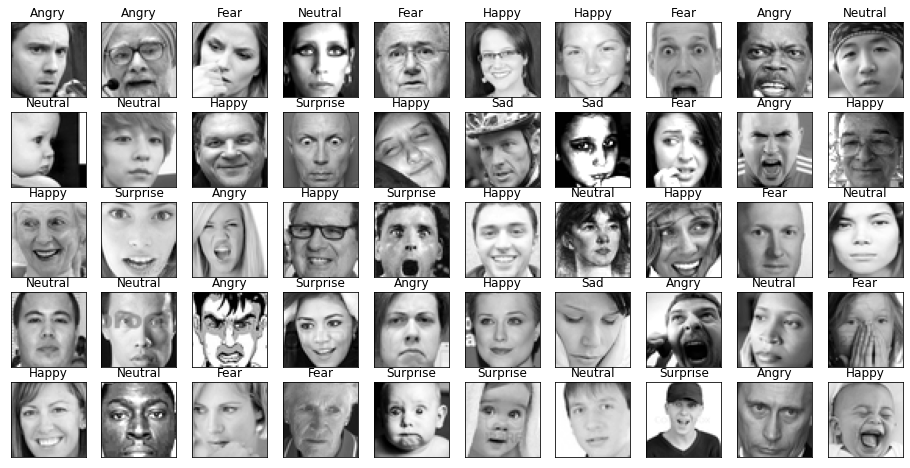

In [6]:
import matplotlib.pyplot as plt
# Displaying 25 images from training dataset in 5x5 matrix
emotion={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'} #for FER2013
#emotion = {0:'anger',1:'contempt',2:'disgust',3:'fear',4:'happy',5:'sadness',6:'surprise'} #for CK+
def plot_image(input_images,labels):
  print("Display 50 images from the train set in the form of 5x5 matrix with their respective labels:")
  plt.figure(figsize=[16,8])
  for i in range(50):
    plt.subplot(5,10,1+i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(input_images[i].reshape([48,48]), cmap='gray')
    plt.title(emotion[int(labels[i])])
  plt.show()

plot_image(x_train,y_train)


Begin validation fold number:  1
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.1
44/44 [==============================] - 29s 486ms/step - loss: 2.0097 - accuracy: 0.2627 - val_loss: 2.3717 - val_accuracy: 0.2661
Epoch 2/50
Learning rate:  0.1
44/44 [==============================] - 20s 438ms/step - loss: 1.9356 - accuracy: 0.2748 - val_loss: 2.0433 - val_accuracy: 0.1974
Epoch 3/50
Learning rate:  0.1
44/44 [==============================] - 20s 440ms/step - loss: 1.9086 - accuracy: 0.2842 - val_loss: 1.9741 - val_accuracy: 0.2901
Epoch 4/50
Learning rate:  0.1
44/44 [==============================] - 20s 446ms/step - loss: 1.8342 - accuracy: 0.3404 - val_loss: 1.9728 - val_accuracy: 0.2241
Epoch 5/50
Learning rate:  0.1
44/44 [==============================] - 20s 445ms/step - loss: 1.7056 - accuracy: 0.4064 - val_loss: 1.9191 - val_accuracy: 0.3360
Epoch 6/50
Learning rate:  0.1
44/44 [==============================] - 20s 445ms/step - loss: 1.6161 - accuracy: 0.4

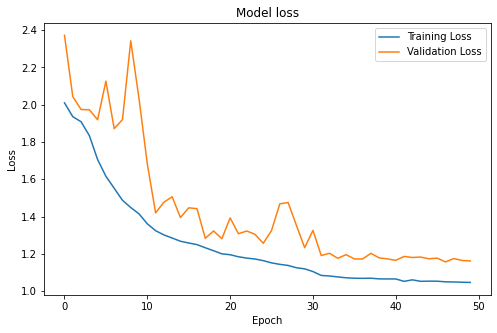

Plot the accuracy (Train and Validation)


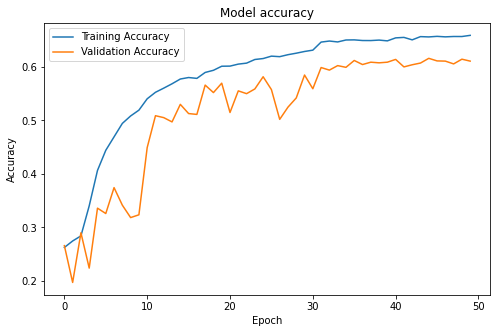

87/87 [==============================] - 2s 21ms/step - loss: 1.1470 - accuracy: 0.6240


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Begin validation fold number:  2
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.1
44/44 [==============================] - 21s 454ms/step - loss: 1.1070 - accuracy: 0.6338 - val_loss: 1.3127 - val_accuracy: 0.5649
Epoch 2/50
Learning rate:  0.1
44/44 [==============================] - 20s 454ms/step - loss: 1.1188 - accuracy: 0.6291 - val_loss: 1.4304 - val_accuracy: 0.5082
Epoch 3/50
Learning rate:  0.1
44/44 [==============================] - 20s 454ms/step - loss: 1.1063 - accuracy: 0.6329 - val_loss: 1.1288 - val_accuracy: 0.6280
Epoch 4/50
Learning rate:  0.1
44/44 [==============================] - 20s 454ms/step - loss: 1.0935 - accuracy: 0.6391 - val_loss: 1.1958 - val_accuracy: 0.6045
Epoch 5/50
Learning rate:  0.1
44/44 [==============================] - 21s 457ms/step - loss: 1.0896 - accuracy: 0.6365 - val_loss: 1.3014 - val_accuracy: 0.5709
Epoch 6/50
Learning rate:  0.1
44/44 [==============================] - 21s 461ms/step - loss: 1.0745 - accuracy: 0.6

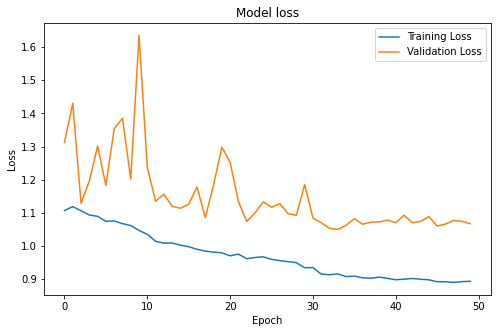

Plot the accuracy (Train and Validation)


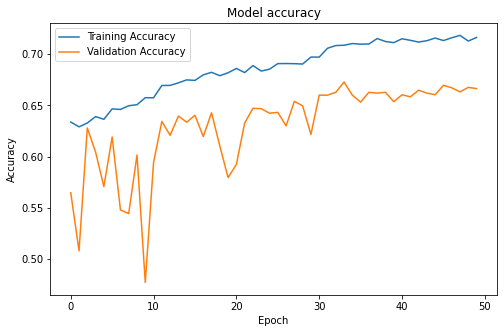

87/87 [==============================] - 2s 22ms/step - loss: 1.0956 - accuracy: 0.6581
Begin validation fold number:  3
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.1
44/44 [==============================] - 21s 458ms/step - loss: 0.9626 - accuracy: 0.6875 - val_loss: 0.9632 - val_accuracy: 0.6872
Epoch 2/50
Learning rate:  0.1
44/44 [==============================] - 21s 460ms/step - loss: 0.9716 - accuracy: 0.6854 - val_loss: 1.1506 - val_accuracy: 0.6360
Epoch 3/50
Learning rate:  0.1
44/44 [==============================] - 21s 460ms/step - loss: 0.9690 - accuracy: 0.6831 - val_loss: 1.2010 - val_accuracy: 0.6105
Epoch 4/50
Learning rate:  0.1
44/44 [==============================] - 21s 457ms/step - loss: 0.9624 - accuracy: 0.6873 - val_loss: 1.0171 - val_accuracy: 0.6764
Epoch 5/50
Learning rate:  0.1
44/44 [==============================] - 21s 456ms/step - loss: 0.9528 - accuracy: 0.6901 - val_loss: 1.1143 - val_accuracy: 0.6368
Epoch 6/50
Learning rate:  0.

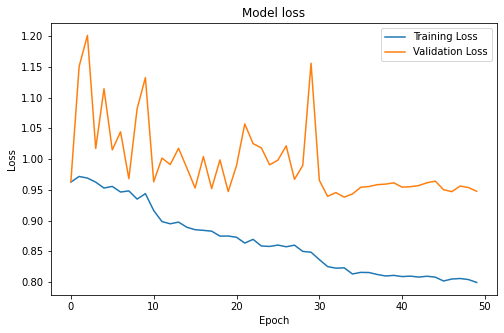

Plot the accuracy (Train and Validation)


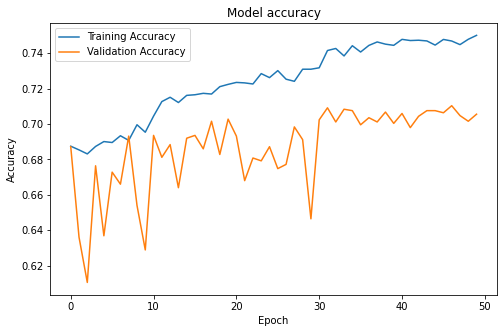

87/87 [==============================] - 2s 22ms/step - loss: 1.0750 - accuracy: 0.6759
Begin validation fold number:  4
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.1
44/44 [==============================] - 21s 460ms/step - loss: 0.8739 - accuracy: 0.7183 - val_loss: 0.9280 - val_accuracy: 0.7040
Epoch 2/50
Learning rate:  0.1
44/44 [==============================] - 21s 459ms/step - loss: 0.8828 - accuracy: 0.7177 - val_loss: 0.8898 - val_accuracy: 0.7111
Epoch 3/50
Learning rate:  0.1
44/44 [==============================] - 21s 457ms/step - loss: 0.8935 - accuracy: 0.7135 - val_loss: 1.0198 - val_accuracy: 0.6676
Epoch 4/50
Learning rate:  0.1
44/44 [==============================] - 21s 460ms/step - loss: 0.8657 - accuracy: 0.7232 - val_loss: 0.9636 - val_accuracy: 0.6896
Epoch 5/50
Learning rate:  0.1
44/44 [==============================] - 21s 458ms/step - loss: 0.8669 - accuracy: 0.7223 - val_loss: 0.9115 - val_accuracy: 0.7084
Epoch 6/50
Learning rate:  0.

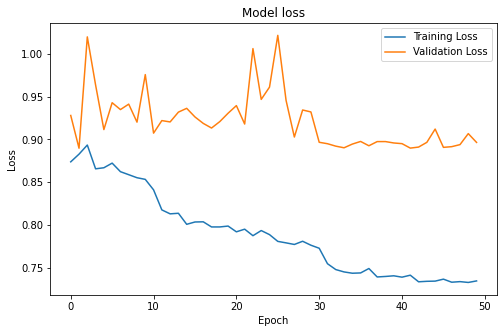

Plot the accuracy (Train and Validation)


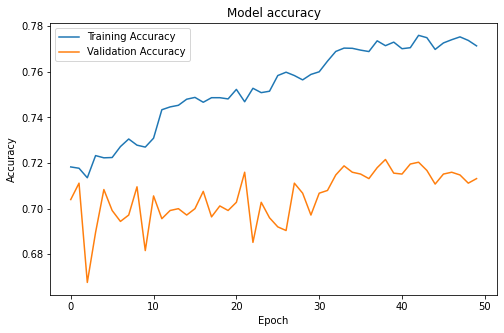

87/87 [==============================] - 2s 22ms/step - loss: 1.0807 - accuracy: 0.6784
Begin validation fold number:  5
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.1
44/44 [==============================] - 21s 458ms/step - loss: 0.7948 - accuracy: 0.7492 - val_loss: 0.9996 - val_accuracy: 0.6780
Epoch 2/50
Learning rate:  0.1
44/44 [==============================] - 21s 455ms/step - loss: 0.8161 - accuracy: 0.7427 - val_loss: 0.8636 - val_accuracy: 0.7235
Epoch 3/50
Learning rate:  0.1
44/44 [==============================] - 21s 456ms/step - loss: 0.8118 - accuracy: 0.7407 - val_loss: 1.0409 - val_accuracy: 0.6736
Epoch 4/50
Learning rate:  0.1
44/44 [==============================] - 21s 461ms/step - loss: 0.8021 - accuracy: 0.7494 - val_loss: 0.9801 - val_accuracy: 0.6896
Epoch 5/50
Learning rate:  0.1
44/44 [==============================] - 21s 458ms/step - loss: 0.8067 - accuracy: 0.7439 - val_loss: 0.8957 - val_accuracy: 0.7131
Epoch 6/50
Learning rate:  0.

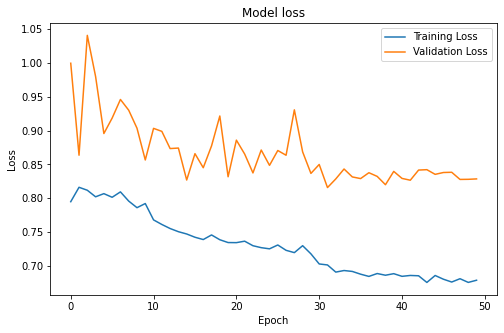

Plot the accuracy (Train and Validation)


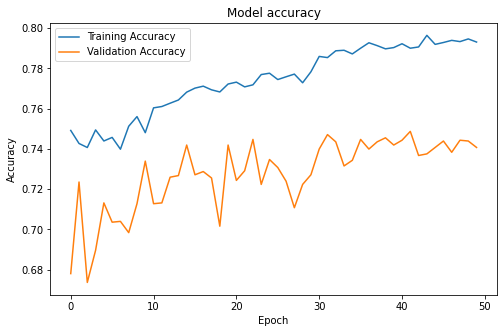

87/87 [==============================] - 2s 22ms/step - loss: 1.0801 - accuracy: 0.6824


In [12]:
#CBAM with cross validation (from fold 1 to 5)

from __future__ import print_function
import keras
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import resnet_v1, mobilenets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os
import callbacks as cb

# Training parameters
batch_size = 512
epochs = 50
data_augmentation = True
num_classes = 7
subtract_pixel_mean = False  # Subtracting pixel mean improves accuracy
attention_module = 'cbam_block'
base_model = 'MobileNet'
# Choose what attention_module to use: cbam_block / se_block / None
model_type = base_model if attention_module==None else base_model+' '+attention_module

x = np.concatenate((x_train, x_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

#x, y = pre_process(x, y)
kfold = KFold(n_splits = 10, shuffle=True, random_state=2021)

# Input image dimensions.
input_shape = x.shape[1:]

# Convert class vectors to binary class matrices.
y = to_categorical(y, num_classes)
y_test = to_categorical(y_test, num_classes)

depth = 20 # For ResNet, specify the depth (e.g. ResNet50: depth=50, ResNet101: Depth=101)
model = resnet_v1.resnet_v1(input_shape=input_shape, depth=depth,num_classes=num_classes, attention_module='cbam_block')
#model = mobilenets.MobileNet(input_shape=input_shape, classes=num_classes, attention_module='cbam_block')
#model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(0.01, decay=1e-3, momentum=0.9),#Adam(), #SGD(decay=2e-5, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
#model.summary()

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
def lr_schedule(epoch):
    lr = 0.1
    if epoch >= (epochs*0.6):
      lr = 0.01
    elif epoch >= (epochs*0.2):
      lr=0.05
    print('Learning rate: ', lr)
    return lr

# 1 cycle learning rate
cbs = cb.OneCycleSchedulerCallback(cyc_iterations= 2 * 23 * math.ceil(len(x_train) / batch_size) + 1,
                                      ramp_iterations=4 * math.ceil(len(x_train) / batch_size),
                                      min_lr=0.01,
                                      max_lr=0.1,
                                      min_mom=0.8,
                                      max_mom=0.95)


lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.01)
callbacks = [checkpoint, lr_reducer, lr_scheduler]


folds = 1
for train, val in kfold.split(x, y):
  print("Begin validation fold number: ", folds)
  # Run training, with or without data augmentation.
  if not data_augmentation:
      print('Not using data augmentation.')
      #history = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,validation_data=(x_val, y_val), shuffle=True,callbacks=callbacks)
      history = model.fit(x[train], y[train],batch_size=batch_size, epochs=epochs,validation_data=(x[val], y[val]),shuffle=True, callbacks=callbacks)
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          # set input mean to 0 over the dataset
          featurewise_center=False,
          # set each sample mean to 0
          samplewise_center=False,
          # divide inputs by std of dataset
          featurewise_std_normalization=False,
          # divide each input by its std
          samplewise_std_normalization=False,
          # apply ZCA whitening
          zca_whitening=False,
          # epsilon for ZCA whitening
          zca_epsilon=1e-06,
          # randomly rotate images in the range (deg 0 to 180)
          rotation_range=0,
          # randomly shift images horizontally
          width_shift_range=0.1,
          # randomly shift images vertically
          height_shift_range=0.1,
          # set range for random shear
          shear_range=0.,
          # set range for random zoom
          zoom_range=0.,
          # set range for random channel shifts
          channel_shift_range=0.,
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          # value used for fill_mode = "constant"
          cval=0.,
          # randomly flip images
          horizontal_flip=True,
          # randomly flip images
          vertical_flip=False,
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for featurewise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x[train])

      # Fit the model on the batches generated by datagen.flow().
      #history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
      history = model.fit(datagen.flow(x[train], y[train], batch_size=batch_size),
                      validation_data=(x[val], y[val]),
                      epochs=epochs, verbose=1, workers=4,
                      callbacks=callbacks)
  # plot the training   
  plot_model_history(history)
  # Score trained model.
  scores = model.evaluate(x_test, y_test)
  model.save('/content/drive/MyDrive/Colab Notebooks/SIT723/my_'+ str(folds) + '_model.h5')
  folds += 1
  if (folds>5):
    break
  


Begin validation fold number:  6
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.1
44/44 [==============================] - 20s 442ms/step - loss: 0.7428 - accuracy: 0.7696 - val_loss: 0.9717 - val_accuracy: 0.7103
Epoch 2/50
Learning rate:  0.1
44/44 [==============================] - 20s 434ms/step - loss: 0.7712 - accuracy: 0.7610 - val_loss: 0.8301 - val_accuracy: 0.7299
Epoch 3/50
Learning rate:  0.1
44/44 [==============================] - 20s 437ms/step - loss: 0.7567 - accuracy: 0.7642 - val_loss: 0.8424 - val_accuracy: 0.7355
Epoch 4/50
Learning rate:  0.1
44/44 [==============================] - 20s 440ms/step - loss: 0.7529 - accuracy: 0.7652 - val_loss: 0.8381 - val_accuracy: 0.7303
Epoch 5/50
Learning rate:  0.1
44/44 [==============================] - 20s 441ms/step - loss: 0.7491 - accuracy: 0.7663 - val_loss: 0.8183 - val_accuracy: 0.7395
Epoch 6/50
Learning rate:  0.1
44/44 [==============================] - 20s 445ms/step - loss: 0.7567 - accuracy: 0.7

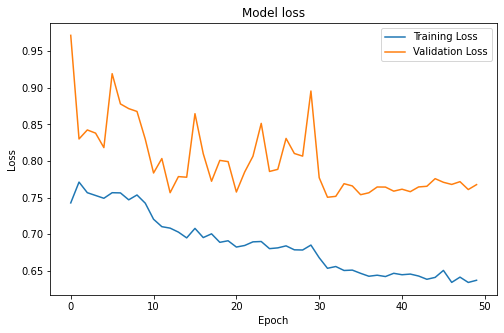

Plot the accuracy (Train and Validation)


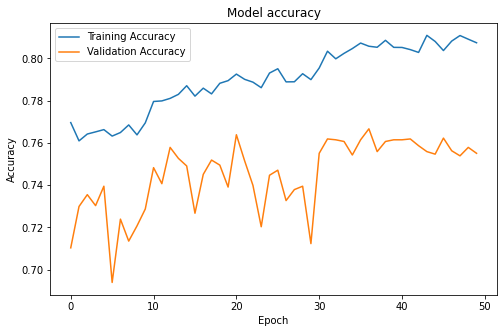

87/87 [==============================] - 2s 21ms/step - loss: 1.0920 - accuracy: 0.6864


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Begin validation fold number:  7
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.1
44/44 [==============================] - 21s 461ms/step - loss: 0.6941 - accuracy: 0.7871 - val_loss: 0.7536 - val_accuracy: 0.7639
Epoch 2/50
Learning rate:  0.1
44/44 [==============================] - 21s 457ms/step - loss: 0.7299 - accuracy: 0.7735 - val_loss: 0.8911 - val_accuracy: 0.7163
Epoch 3/50
Learning rate:  0.1
44/44 [==============================] - 21s 456ms/step - loss: 0.7114 - accuracy: 0.7776 - val_loss: 0.8796 - val_accuracy: 0.7231
Epoch 4/50
Learning rate:  0.1
44/44 [==============================] - 21s 454ms/step - loss: 0.7158 - accuracy: 0.7774 - val_loss: 0.7162 - val_accuracy: 0.7739
Epoch 5/50
Learning rate:  0.1
44/44 [==============================] - 21s 457ms/step - loss: 0.7072 - accuracy: 0.7798 - val_loss: 0.8114 - val_accuracy: 0.7363
Epoch 6/50
Learning rate:  0.1
44/44 [==============================] - 21s 458ms/step - loss: 0.7155 - accuracy: 0.7

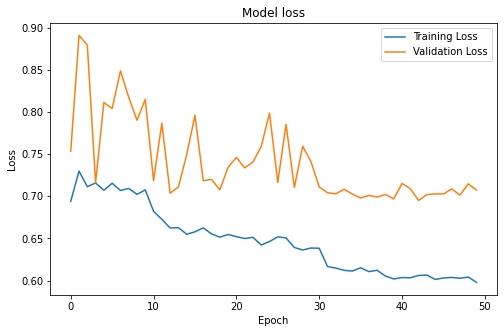

Plot the accuracy (Train and Validation)


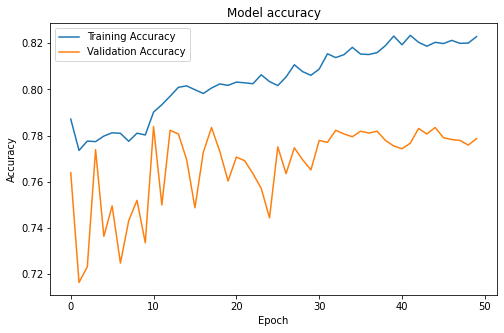

87/87 [==============================] - 2s 22ms/step - loss: 1.0884 - accuracy: 0.6947
Begin validation fold number:  8
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.1
44/44 [==============================] - 21s 455ms/step - loss: 0.6664 - accuracy: 0.7956 - val_loss: 0.6878 - val_accuracy: 0.7871
Epoch 2/50
Learning rate:  0.1
44/44 [==============================] - 20s 453ms/step - loss: 0.6739 - accuracy: 0.7929 - val_loss: 0.7759 - val_accuracy: 0.7591
Epoch 3/50
Learning rate:  0.1
44/44 [==============================] - 21s 456ms/step - loss: 0.6749 - accuracy: 0.7919 - val_loss: 0.6978 - val_accuracy: 0.7843
Epoch 4/50
Learning rate:  0.1
44/44 [==============================] - 21s 454ms/step - loss: 0.6778 - accuracy: 0.7933 - val_loss: 0.7132 - val_accuracy: 0.7703
Epoch 5/50
Learning rate:  0.1
44/44 [==============================] - 21s 456ms/step - loss: 0.6743 - accuracy: 0.7921 - val_loss: 0.7917 - val_accuracy: 0.7463
Epoch 6/50
Learning rate:  0.

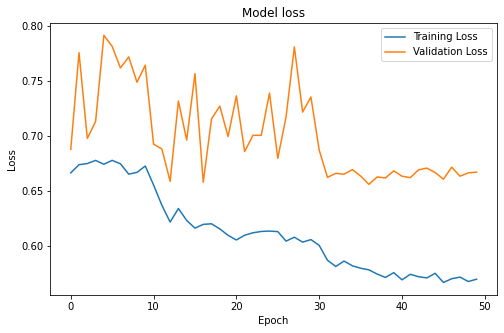

Plot the accuracy (Train and Validation)


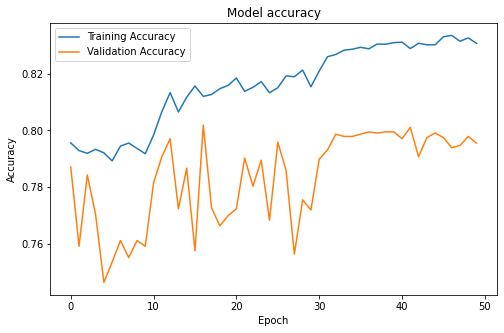

87/87 [==============================] - 2s 22ms/step - loss: 1.0900 - accuracy: 0.7002
Begin validation fold number:  9
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.1
44/44 [==============================] - 22s 488ms/step - loss: 0.6254 - accuracy: 0.8112 - val_loss: 0.6815 - val_accuracy: 0.7830
Epoch 2/50
Learning rate:  0.1
44/44 [==============================] - 21s 460ms/step - loss: 0.6473 - accuracy: 0.8040 - val_loss: 0.7346 - val_accuracy: 0.7594
Epoch 3/50
Learning rate:  0.1
44/44 [==============================] - 21s 457ms/step - loss: 0.6501 - accuracy: 0.7998 - val_loss: 0.6277 - val_accuracy: 0.8034
Epoch 4/50
Learning rate:  0.1
44/44 [==============================] - 21s 456ms/step - loss: 0.6437 - accuracy: 0.8021 - val_loss: 0.6390 - val_accuracy: 0.8002
Epoch 5/50
Learning rate:  0.1
44/44 [==============================] - 21s 458ms/step - loss: 0.6506 - accuracy: 0.8016 - val_loss: 0.6971 - val_accuracy: 0.7862
Epoch 6/50
Learning rate:  0.

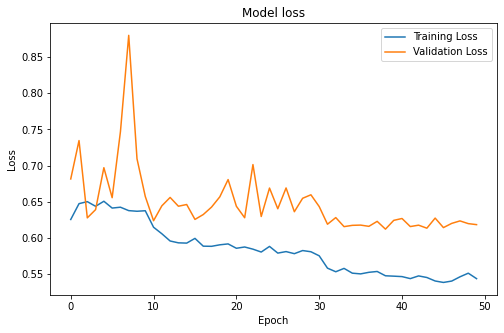

Plot the accuracy (Train and Validation)


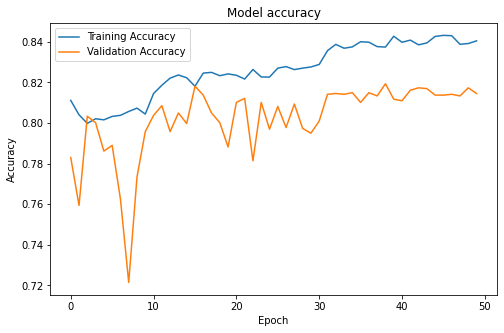

87/87 [==============================] - 2s 23ms/step - loss: 1.1064 - accuracy: 0.7049
Begin validation fold number:  10
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.1
44/44 [==============================] - 21s 458ms/step - loss: 0.6041 - accuracy: 0.8167 - val_loss: 0.6816 - val_accuracy: 0.7842
Epoch 2/50
Learning rate:  0.1
44/44 [==============================] - 21s 460ms/step - loss: 0.6227 - accuracy: 0.8092 - val_loss: 0.6186 - val_accuracy: 0.8046
Epoch 3/50
Learning rate:  0.1
44/44 [==============================] - 21s 458ms/step - loss: 0.6164 - accuracy: 0.8138 - val_loss: 0.6661 - val_accuracy: 0.7954
Epoch 4/50
Learning rate:  0.1
44/44 [==============================] - 21s 460ms/step - loss: 0.6159 - accuracy: 0.8120 - val_loss: 0.6413 - val_accuracy: 0.7962
Epoch 5/50
Learning rate:  0.1
44/44 [==============================] - 21s 459ms/step - loss: 0.6112 - accuracy: 0.8143 - val_loss: 0.6783 - val_accuracy: 0.7842
Epoch 6/50
Learning rate:  0

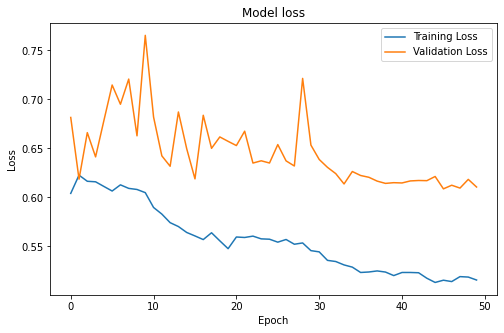

Plot the accuracy (Train and Validation)


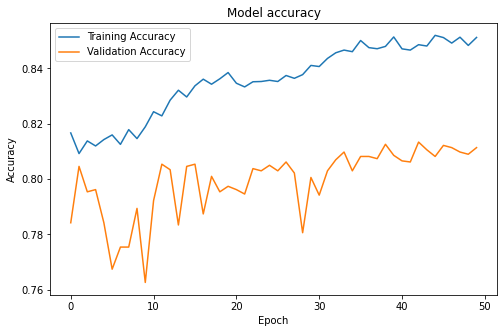

87/87 [==============================] - 2s 23ms/step - loss: 1.1115 - accuracy: 0.7056


In [13]:
#CBAM with cross validation (from fold 6 to 10)

folds = 1
for train, val in kfold.split(x, y):
  if folds<6:
    folds +=1
    continue
  print("Begin validation fold number: ", folds)
  # Run training, with or without data augmentation.
  if not data_augmentation:
      print('Not using data augmentation.')
      #history = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,validation_data=(x_val, y_val), shuffle=True,callbacks=callbacks)
      history = model.fit(x[train], y[train],batch_size=batch_size, epochs=epochs,validation_data=(x[val], y[val]),shuffle=True, callbacks=callbacks)
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          # set input mean to 0 over the dataset
          featurewise_center=False,
          # set each sample mean to 0
          samplewise_center=False,
          # divide inputs by std of dataset
          featurewise_std_normalization=False,
          # divide each input by its std
          samplewise_std_normalization=False,
          # apply ZCA whitening
          zca_whitening=False,
          # epsilon for ZCA whitening
          zca_epsilon=1e-06,
          # randomly rotate images in the range (deg 0 to 180)
          rotation_range=0,
          # randomly shift images horizontally
          width_shift_range=0.1,
          # randomly shift images vertically
          height_shift_range=0.1,
          # set range for random shear
          shear_range=0.,
          # set range for random zoom
          zoom_range=0.,
          # set range for random channel shifts
          channel_shift_range=0.,
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          # value used for fill_mode = "constant"
          cval=0.,
          # randomly flip images
          horizontal_flip=True,
          # randomly flip images
          vertical_flip=False,
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for featurewise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x[train])

      # Fit the model on the batches generated by datagen.flow().
      #history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
      history = model.fit(datagen.flow(x[train], y[train], batch_size=batch_size),
                      validation_data=(x[val], y[val]),
                      epochs=epochs, verbose=1, workers=4,
                      callbacks=callbacks)
  # plot the training   
  plot_model_history(history)
  # Score trained model.
  scores = model.evaluate(x_test, y_test)
  model.save('/content/drive/MyDrive/Colab Notebooks/SIT723/my_'+ str(folds) + '_model.h5')
  folds += 1


In [15]:
# load the save model
from keras.models import load_model
for i in range(1,11,1):
  loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/SIT723/my_'+ str(i) + '_model.h5')
  score = loaded_model.evaluate(x_test, y_test)

87/87 [==============================] - 3s 21ms/step - loss: 1.1115 - accuracy: 0.7056


Labels Dictionary:
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
Number of predition samples =  2755


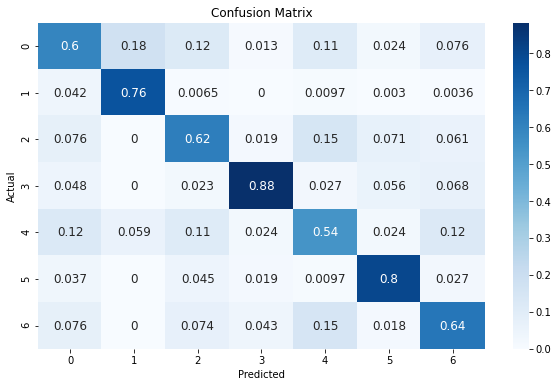

In [16]:
#test images
from sklearn.metrics import confusion_matrix
import seaborn as sn
emotion={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'} #for FER2013

print('Labels Dictionary:')
print(emotion)
print('Number of predition samples = ', len(x_test))
pred = model.predict(x_test)
cm = confusion_matrix( np.argmax(y_test,1),pred.argmax(1),normalize='pred')
#cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize =(10,6))
sn.heatmap(cm, annot=True, annot_kws={"size": 12},cmap=plt.cm.Blues) # font size
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()